<a href="https://colab.research.google.com/github/erinmcmahon26/Company-Bankruptcy-Prediction-Kaggle/blob/main/Company_Bankruptcy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Ingest Data

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report 
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVR
from sklearn.linear_model import SGDClassifier
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [2]:
df_bank = pd.read_csv('https://raw.githubusercontent.com/erinmcmahon26/Company-Bankruptcy-Prediction-Kaggle/main/company_bankruptcy.csv')

In [3]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

### EDA

In [4]:
df_bank.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,...,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.115001,0.190661,0.190633,0.190672,0.228813,0.323482,1.328641e+06,0.109091,0.184361,0.022408,0.847980,0.689146,0.689150,0.217639,5.508097e+09,1.566212e+06,0.264248,0.379677,4.032850e+05,8.376595e+06,0.630991,4.416337e+06,0.113177,0.886823,0.008783,...,0.522273,0.124095,3.592902e+06,3.715999e+07,0.090673,0.353828,0.277395,5.580680e+07,0.761599,0.735817,0.331410,5.416004e+07,0.934733,0.002549,0.029184,1.195856e+09,2.163735e+09,0.594006,2.471977e+09,0.671531,1.220121e+06,0.761599,0.331410,0.115645,0.649731,0.461849,0.593415,0.315582,0.031506,0.001173,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686

In [5]:
df_bank.columns

Index(['Bankrupt?', ' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' Operating Profit

In [6]:
# drop duplicate columns
#df_bank = df_bank.loc[:,~df_bank.columns.duplicated()]

In [7]:
df_bank['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

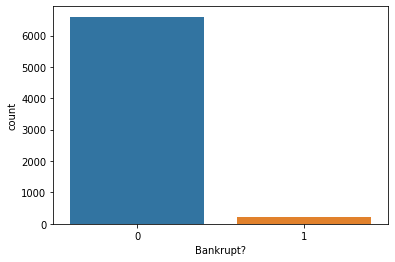

In [8]:
sns.countplot(x='Bankrupt?', data=df_bank)

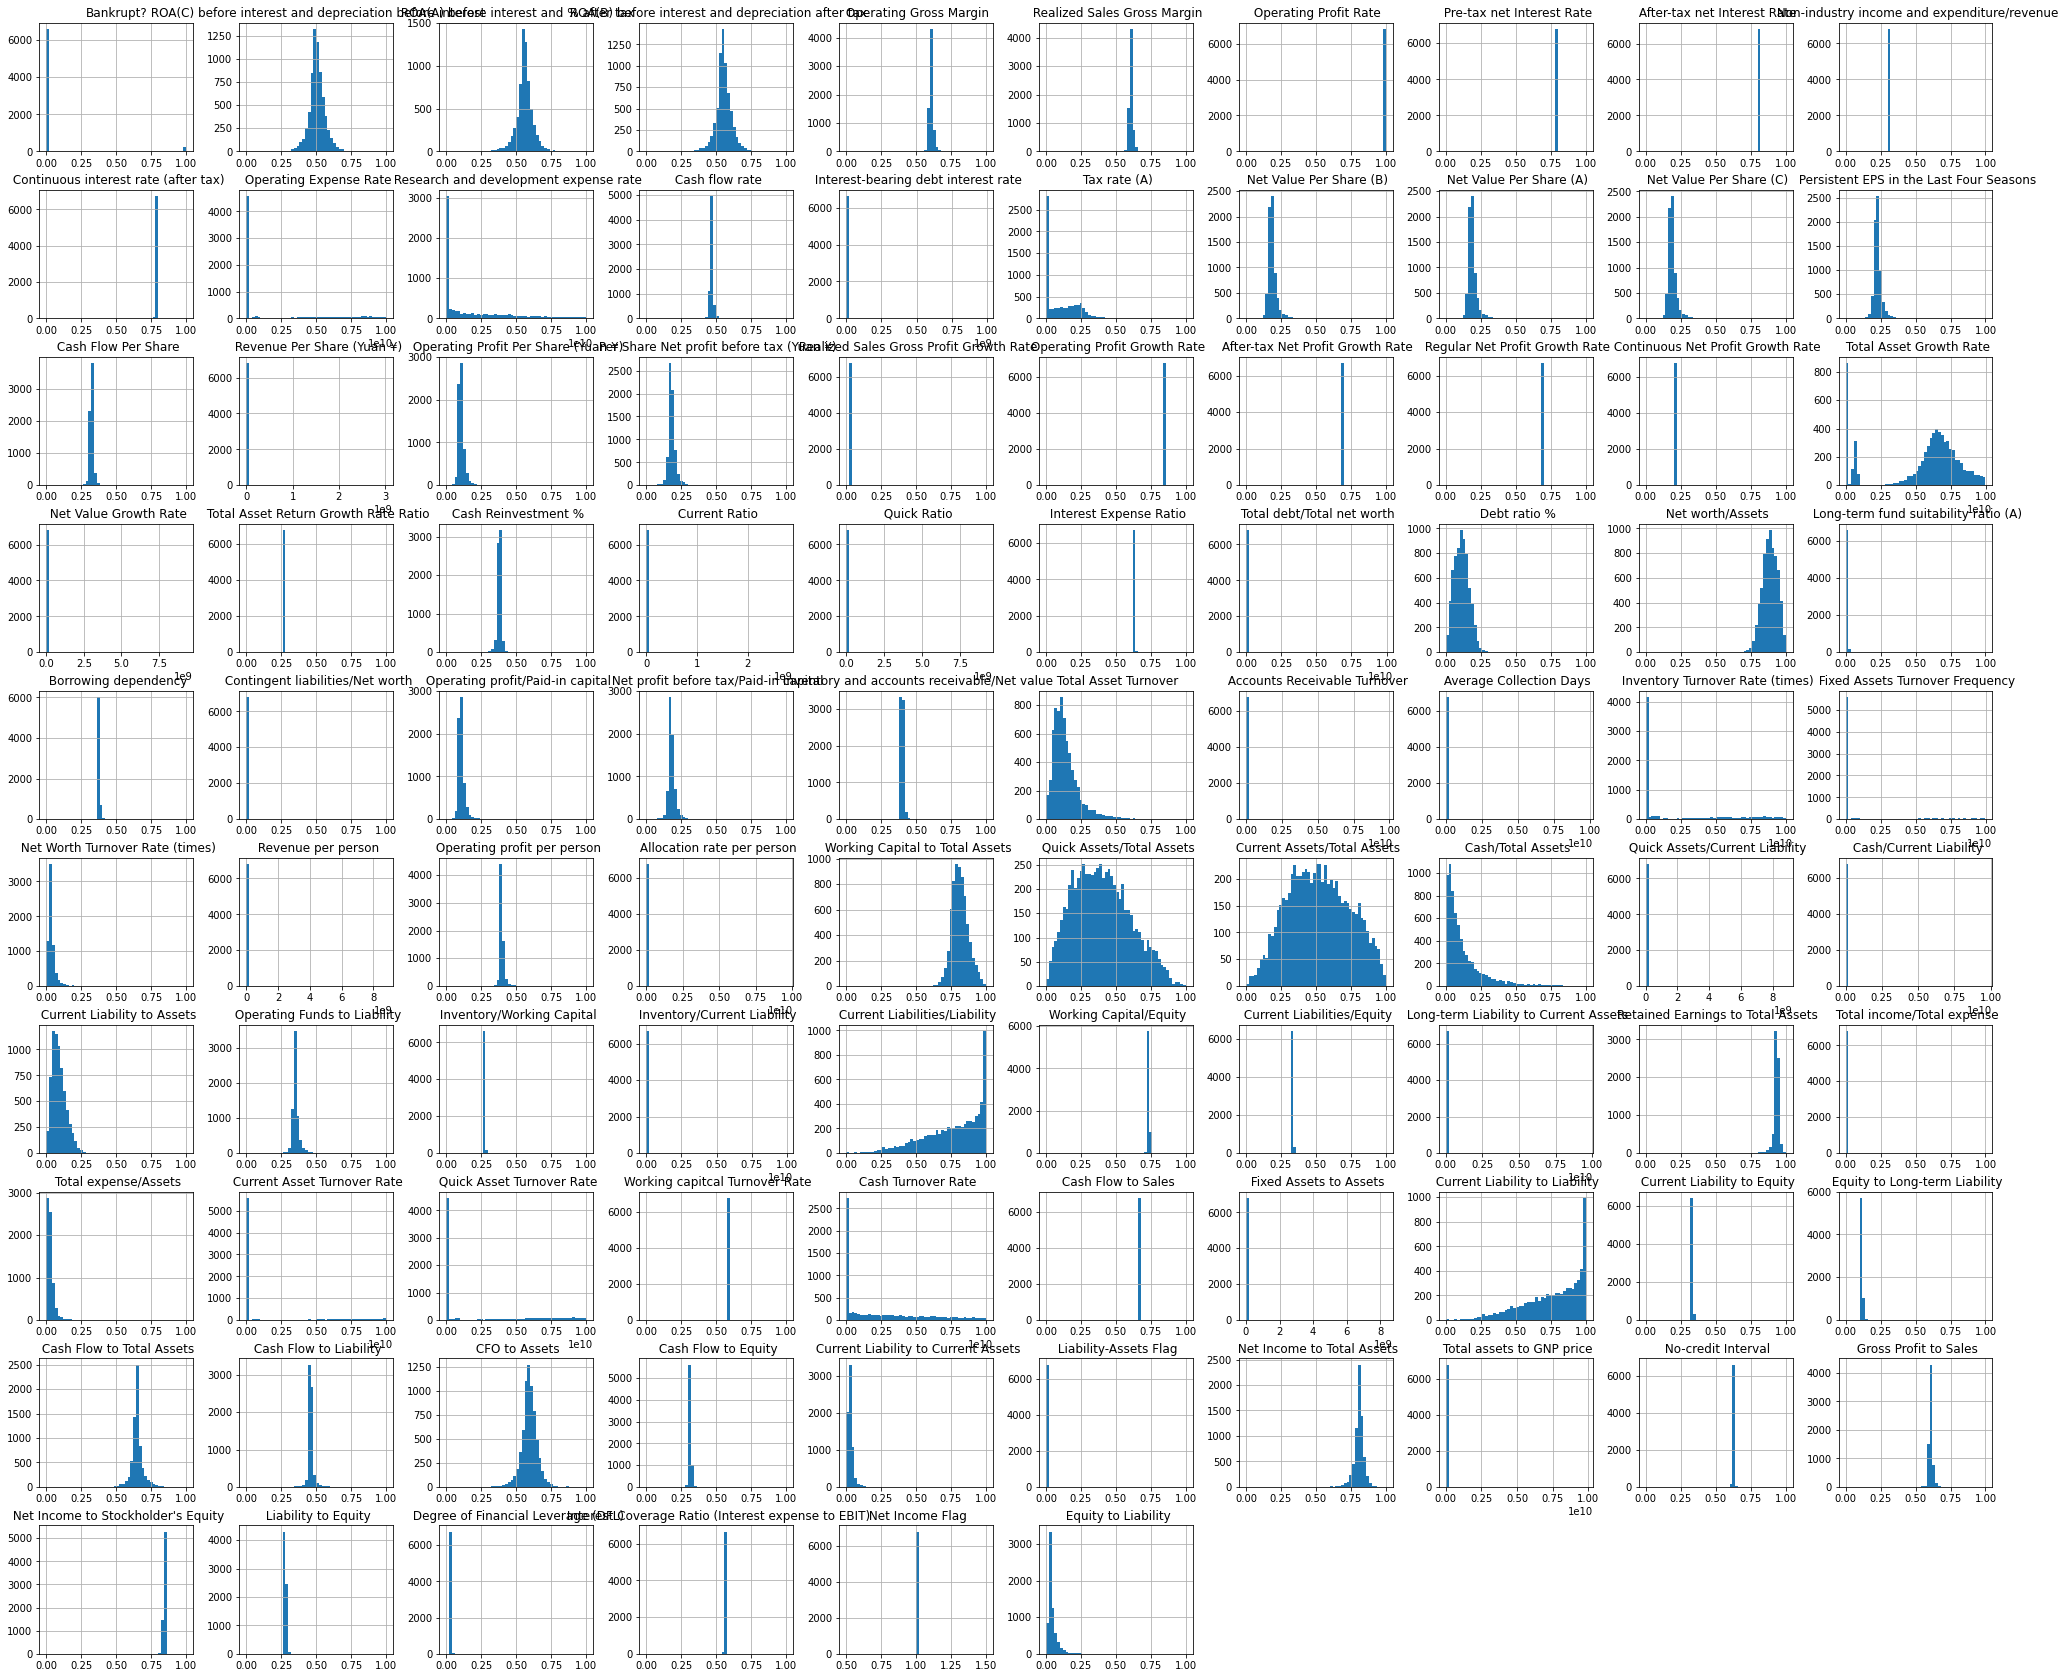

In [9]:
df_bank.hist(figsize = (35,30), bins = 50)
plt.show()

In [10]:
corr_matrix = df_bank.corr()

In [11]:
corr_matrix['Bankrupt?'][corr_matrix['Bankrupt?'] > 0]

Bankrupt?                                       1.000000
 Net Value Growth Rate                          0.065329
 Quick Ratio                                    0.025058
 Total debt/Total net worth                     0.012314
 Debt ratio %                                   0.250161
 Long-term fund suitability ratio (A)           0.016920
 Borrowing dependency                           0.176543
 Contingent liabilities/Net worth               0.070455
 Inventory and accounts receivable/Net value    0.075278
 Fixed Assets Turnover Frequency                0.072818
 Net Worth Turnover Rate (times)                0.021089
 Revenue per person                             0.039718
 Allocation rate per person                     0.002829
 Cash/Current Liability                         0.077921
 Current Liability to Assets                    0.194494
 Inventory/Current Liability                    0.000822
 Current Liabilities/Equity                     0.153828
 Long-term Liability to Current

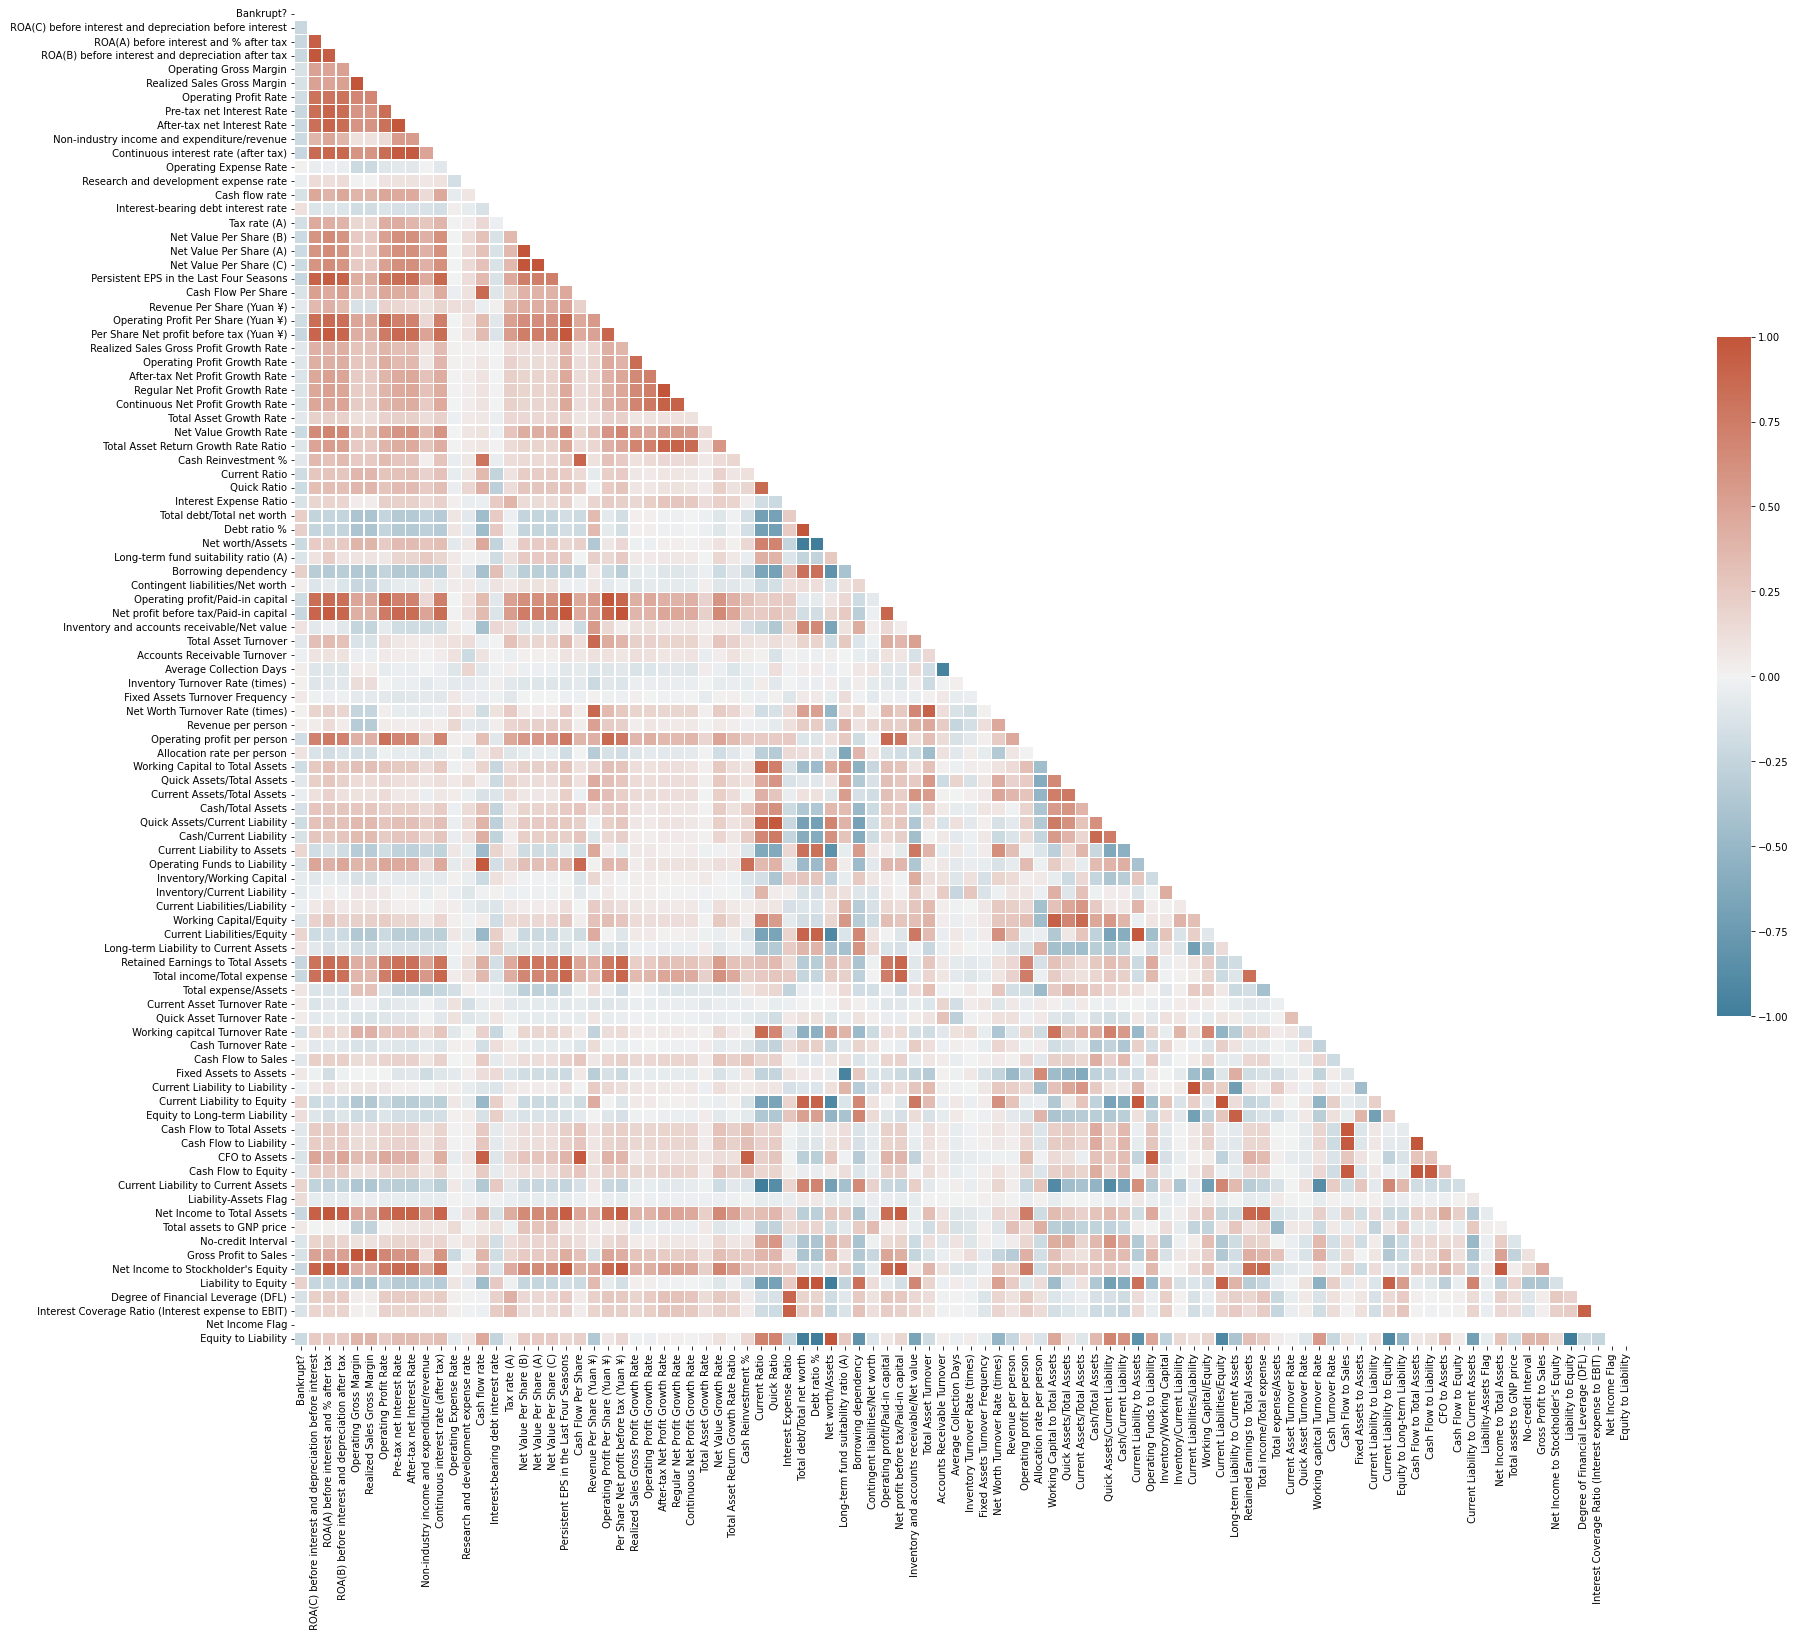

In [12]:
f, ax = plt.subplots(figsize=(30, 25))
mat = df_bank.corr('spearman')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0,# annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [13]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(df_bank.values, i) for i in range(df_bank.shape[1])]
vif['variable'] = df_bank.columns
vif

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF,variable
0,1.255015e+00,Bankrupt?
1,6.930177e+01,ROA(C) before interest and depreciation befor...
2,4.425140e+01,ROA(A) before interest and % after tax
3,1.032851e+02,ROA(B) before interest and depreciation after...
4,6.557756e+07,Operating Gross Margin
...,...,...
91,4.704476e+02,Liability to Equity
92,1.004920e+00,Degree of Financial Leverage (DFL)
93,1.006994e+00,Interest Coverage Ratio (Interest expense to ...
94,0.000000e+00,Net Income Flag


Since the dataset is so skewed, I have split the data into two equal samples. The will be some error associated with the models because of this, but the models will no longer be based mostly on chance because of it. There are significantly more companies that have not gone bankrupt than have gone bankrupt therefore it wouldn't be the hard to always "guess" that a company did not go bankrupt when that is most of the data (about 97%/3% split). 

In [14]:
# let's see what happens if we split the dataset into equal bankrupt/not bankrupt 
bankrupt_sample = df_bank[df_bank['Bankrupt?'] == 0][0:220]
non_bankrupt_sample = df_bank[df_bank['Bankrupt?'] == 1]
new_df_bank = pd.concat([bankrupt_sample,non_bankrupt_sample],axis = 0)
new_df_bank.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
6,0,0.390923,0.445704,0.436158,0.619950,0.619950,0.998993,0.797012,0.808960,0.302814,0.781180,3.984834e-04,7.300000e+08,0.461020,0.000805,0.000000,0.158822,0.158822,0.158822,0.161482,0.316687,0.030915,0.099910,0.128945,0.022112,0.848322,0.688590,0.688590,0.217604,5.720000e+09,0.000352,0.263032,0.375303,0.004672,0.002869,0.629988,0.024441,0.216102,0.783898,0.005005,...,0.295221,0.022989,0.003974,0.001050,0.115920,0.340081,0.276643,0.002159,0.508089,0.728731,0.337392,0.009347,0.911441,0.002121,0.092802,1.058011e-04,9.560000e+09,0.593893,2.390000e+09,0.671562,0.355854,0.508089,0.337392,0.120561,0.630419,0.457785,0.560653,0.310296,0.060765,0,0.736619,0.018372,0.623655,0.619949,0.829980,0.292504,0.026622,0.564200,1,0.015663
7,0,0.508361,0.570922,0.559077,0.601738,0.601717,0.999009,0.797449,0.809362,0.303545,0.781621,9.000000e+09,5.090000e+07,0.467024,0.000630,0.157607,0.176984,0.176984,0.176984,0.225206,0.324114,0.042561,0.104796,0.180462,0.022114,0.848082,0.689535,0.689535,0.217633,6.630000e+09,0.000451,0.264112,0.384235,0.009657,0.007305,0.631379,0.005278,0.108202,0.891798,0.005640,...,0.447942,0.014616,0.007565,0.000888,0.087042,0.353511,0.277275,0.005756,0.755770,0.734946,0.329804,0.005346,0.935449,0.002360,0.025482,7.290000e+09,6.180000e+09,0.593937,7.340000e+08,0.671572,0.218473,0.755770,0.329804,0.114508,0.641553,0.458954,0.610091,0.314364,0.030201,0,0.815350,0.010005,0.623843,0.601739,0.841459,0.278607,0.027031,0.566089,1,0.034889
8,0,0.488519,0.545137,0.543284,0.603612,0.603612,0.998961,0.797414,0.809338,0.303584,0.781598,1.687136e-04,0.000000e+00,0.463142,0.000737,0.005871,0.184189,0.184189,0.184189,0.218398,0.318773,0.026604,0.095188,0.173157,0.022128,0.848159,0.689924,0.689924,0.217654,6.890000e+09,0.000453,0.264151,0.377994,0.013499,0.011823,0.630915,0.002266,0.

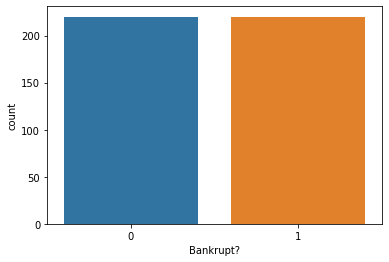

In [15]:
sns.countplot(x='Bankrupt?', data=new_df_bank)

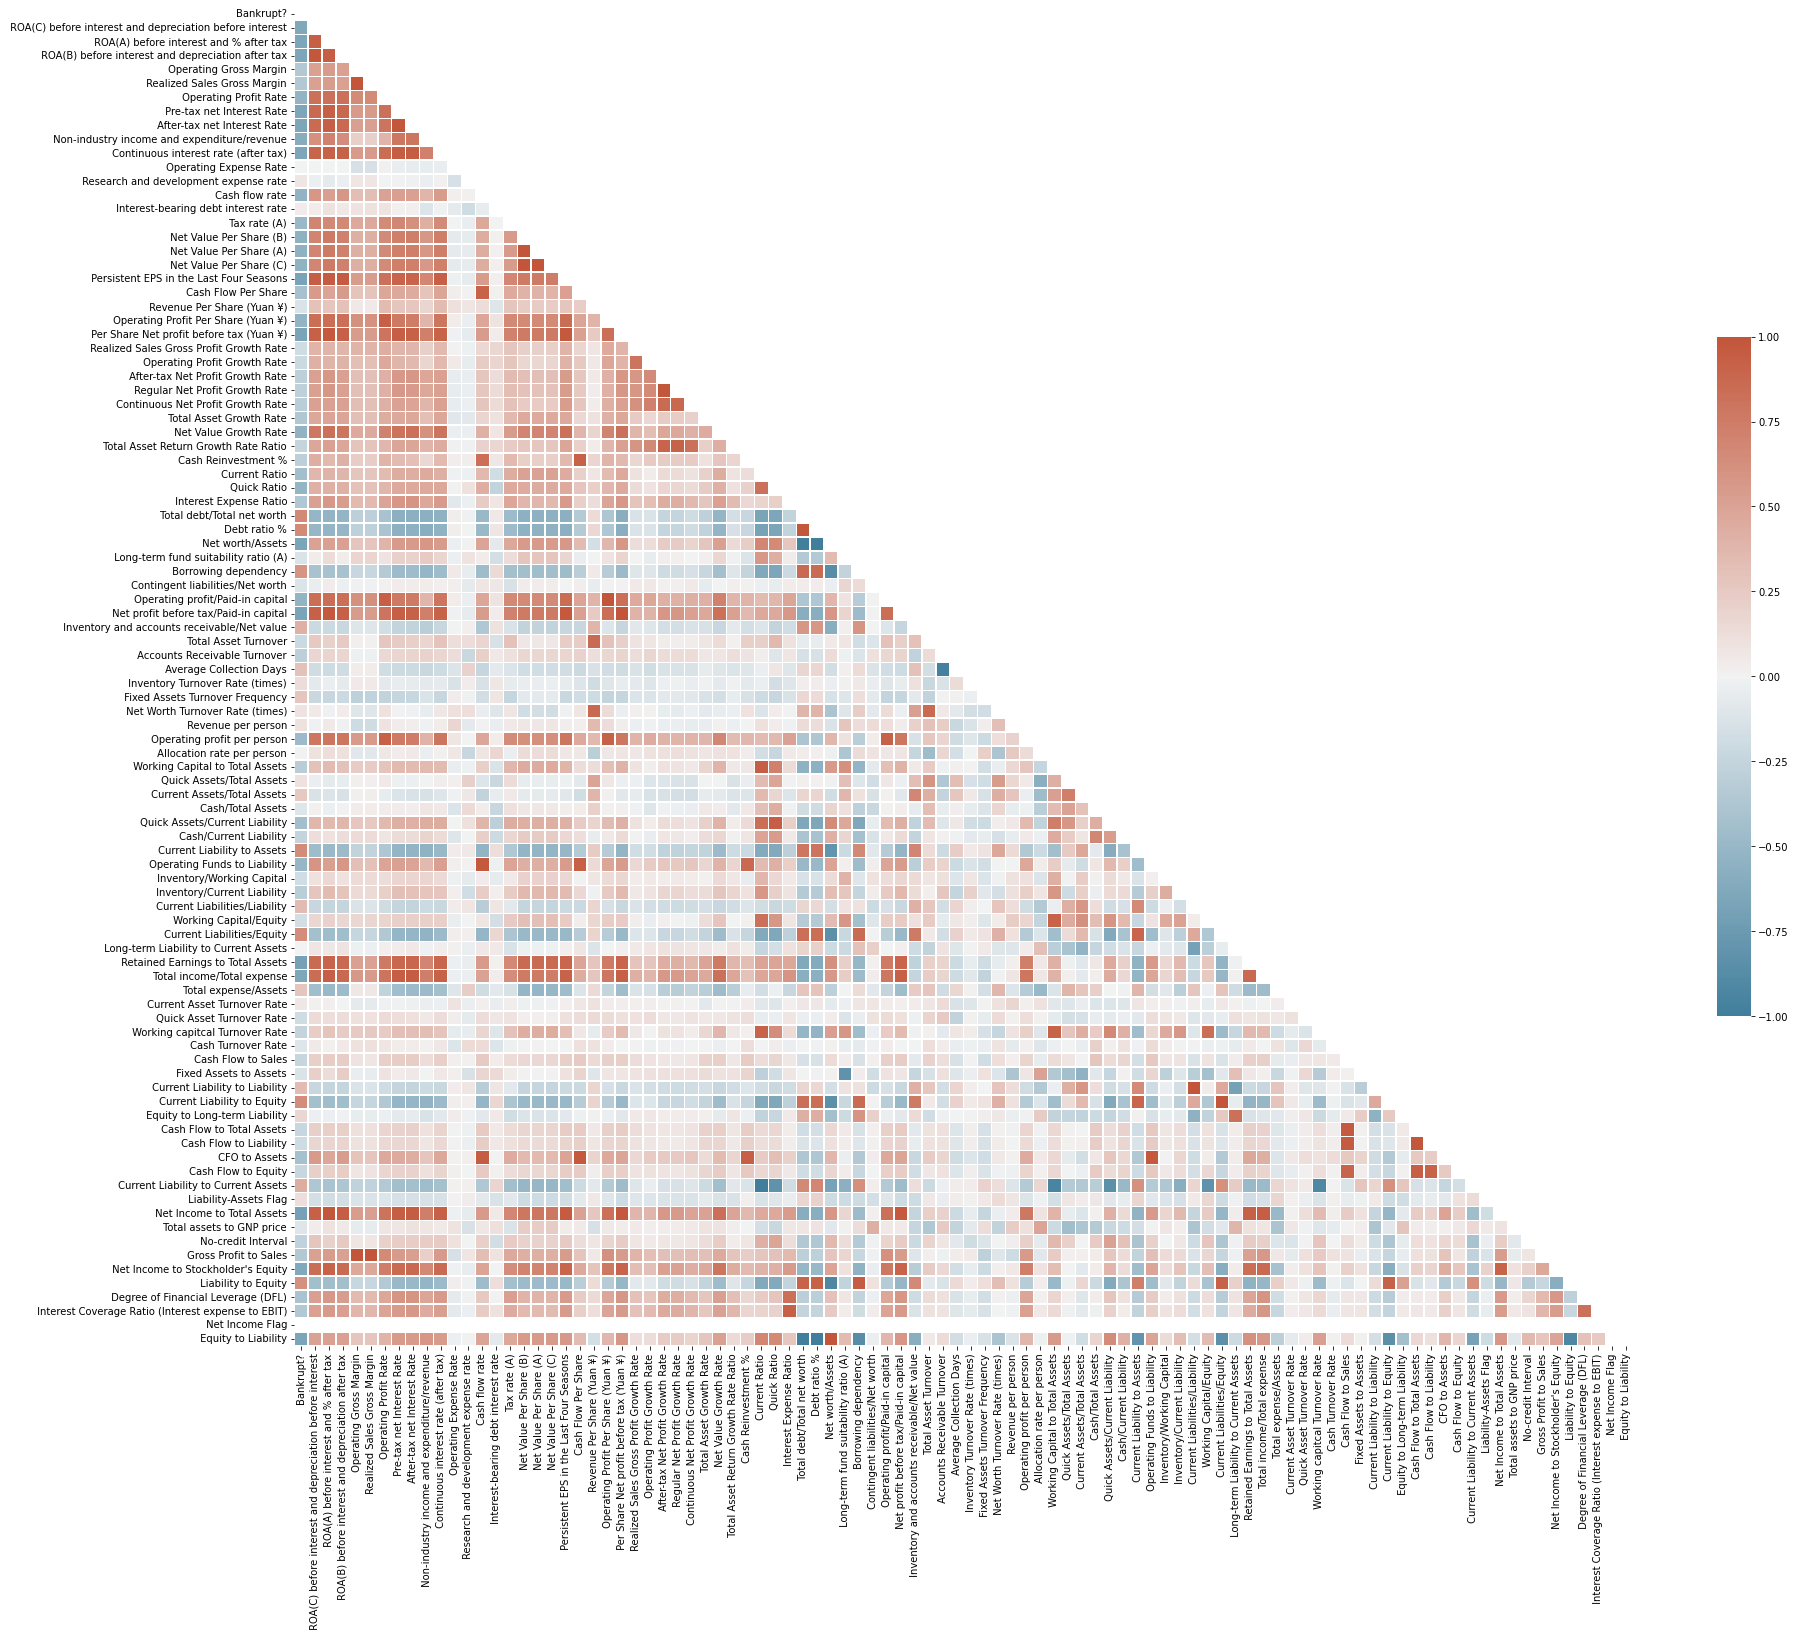

In [16]:
f, ax = plt.subplots(figsize=(30, 25))
mat = new_df_bank.corr('spearman')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0,# annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [17]:
corr_matrix2 = new_df_bank

In [18]:
corr_matrix2['Bankrupt?'][corr_matrix2['Bankrupt?'] > 0]

0       1
1       1
2       1
3       1
4       1
       ..
6591    1
6640    1
6641    1
6642    1
6728    1
Name: Bankrupt?, Length: 220, dtype: int64

After taking an even sample of companies that went bankrupt and companies that did not, it is easier to see what variables are and are not correlated to our Bankrupt? column. 

In [19]:
y = new_df_bank['Bankrupt?']
x = new_df_bank.drop('Bankrupt?', axis=1)

In [20]:
scaler = StandardScaler()
x = scaler.fit_transform(x.astype(np.float64))

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

### Model Selection

#### SGD Classifier

In [22]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train)


SGDClassifier(random_state=42)

In [23]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))

In [24]:
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.80508475, 0.82051282, 0.82051282])

In [25]:
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train, cv=3)

In [26]:
confusion_matrix(y_train, y_train_pred)

array([[137,  32],
       [ 33, 150]])

In [27]:
conf_mx = confusion_matrix(y_train, y_train_pred)

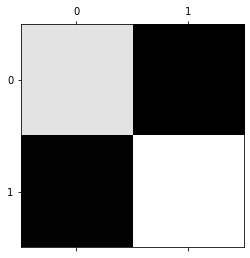

In [28]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

A confusion matrix counts the number of instances that the model was able to classify bankcrupt (yes or no) properly. The first row is the negative class (not bankrupt) and the second row is the positive class (bankrupt). The first column represents the actual class and the second column represents the predicted class. The perfect classifier would produce non-zero values only in the top left and bottom right. This states that the model wrongly classified 45 companies as not bankcrupt (false positives) and wrongly classified 165 companies as bankcrupt (false negatives). The plot is a representation of the confusion matrix. 

In [29]:
precision_score(y_train, y_train_pred)

0.8241758241758241

In [30]:
recall_score(y_train, y_train_pred)

0.819672131147541

In [31]:
f1_score(y_train, y_train_pred)

0.821917808219178

In [32]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_pred)

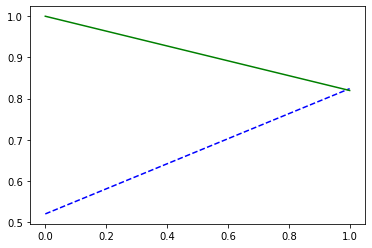

In [33]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Above we looked at precision, recall, and F score. Our current classifier has 82% precision, 82% recall, and an F score of 0.82. Depending on what the business question is, adjustments for precision and recall may need to be made.   

In [34]:
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)

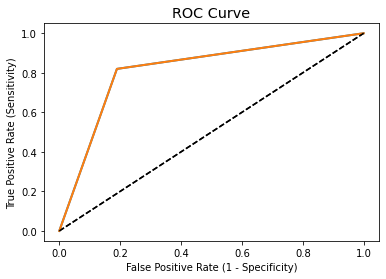

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1], [0,1], 'k--' )  
    plt.rcParams['font.size'] = 12
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 

plot_roc_curve(fpr, tpr)
plt.show()

In [36]:
sgd_auc = roc_auc_score(y_train, y_train_pred)
sgd_auc

0.8151615093607527

After our summary statistics as well as plotting our ROC graph, we have a model that can accurately predict if a company will go bankrupt or not at abou 82%. Additional feature and model selection needs to be completed to find a higher accuracy model. 

#### SVM Classifier

##### Base SVM model 

accuracy score =  0.8522727272727273
Classification Report               precision    recall  f1-score   support

           0       0.91      0.82      0.87        51
           1       0.79      0.89      0.84        37

    accuracy                           0.85        88
   macro avg       0.85      0.86      0.85        88
weighted avg       0.86      0.85      0.85        88



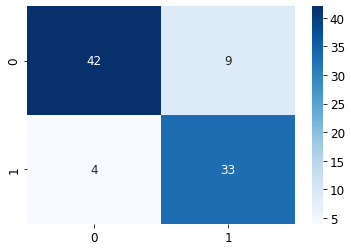

In [37]:
svc = SVC()
svc.fit(x_train, y_train)

sy_pred = svc.predict(x_test)
cm = confusion_matrix(y_test, sy_pred)

sva = accuracy_score(y_test, sy_pred)
print('accuracy score = ',accuracy_score(y_test, sy_pred))
print("Classification Report",classification_report(y_test, sy_pred))

sns.heatmap(cm,annot=True,fmt="d",cmap = "Blues")

##### Linear SVM

accuracy score =  0.8409090909090909
Classification Report               precision    recall  f1-score   support

           0       0.89      0.82      0.86        51
           1       0.78      0.86      0.82        37

    accuracy                           0.84        88
   macro avg       0.84      0.84      0.84        88
weighted avg       0.85      0.84      0.84        88



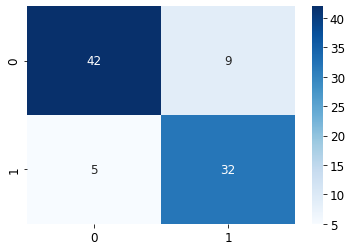

In [38]:
l_svc = SVC(kernel = 'linear')
l_svc.fit(x_train, y_train)

sy_pred = l_svc.predict(x_test)
cm = confusion_matrix(y_test, sy_pred)

lsva = accuracy_score(y_test, sy_pred)
print('accuracy score = ',accuracy_score(y_test, sy_pred))
print("Classification Report",classification_report(y_test, sy_pred))

sns.heatmap(cm,annot=True,fmt="d",cmap = "Blues")

##### Polynomial SVM

accuracy score =  0.75
Classification Report               precision    recall  f1-score   support

           0       0.70      0.98      0.82        51
           1       0.94      0.43      0.59        37

    accuracy                           0.75        88
   macro avg       0.82      0.71      0.71        88
weighted avg       0.80      0.75      0.72        88



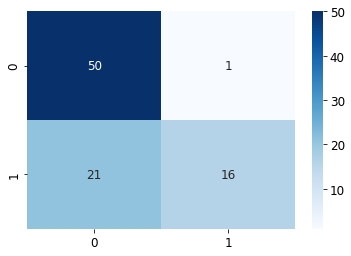

In [39]:
p_svc = SVC(kernel = 'poly')
p_svc.fit(x_train, y_train)

sy_pred = p_svc.predict(x_test)
cm = confusion_matrix(y_test, sy_pred)

psva = accuracy_score(y_test, sy_pred)
print('accuracy score = ',accuracy_score(y_test, sy_pred))
print("Classification Report",classification_report(y_test, sy_pred))

sns.heatmap(cm,annot=True,fmt="d",cmap = "Blues")

##### RBF SVM

accuracy score =  0.8522727272727273
Classification Report               precision    recall  f1-score   support

           0       0.91      0.82      0.87        51
           1       0.79      0.89      0.84        37

    accuracy                           0.85        88
   macro avg       0.85      0.86      0.85        88
weighted avg       0.86      0.85      0.85        88



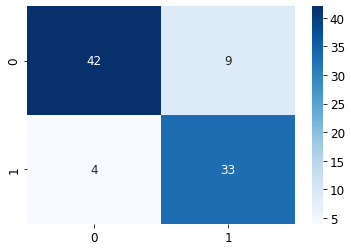

In [40]:
rbf_svc = SVC(kernel = 'rbf')
rbf_svc.fit(x_train, y_train)

sy_pred = rbf_svc.predict(x_test)
cm = confusion_matrix(y_test, sy_pred)

rsva = accuracy_score(y_test, sy_pred)
print('accuracy score = ',accuracy_score(y_test, sy_pred))
print("Classification Report",classification_report(y_test, sy_pred))

sns.heatmap(cm,annot=True,fmt="d",cmap = "Blues")

In [41]:
sfpr, stpr, sthresholds = roc_curve(y_test, sy_pred)

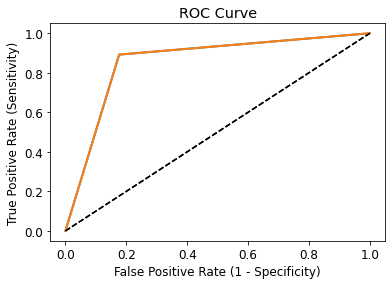

In [42]:
plot_roc_curve(sfpr, stpr)
plt.show()

##### Hyperparameter Optimization

In [43]:
from sklearn.model_selection import GridSearchCV


# import SVC classifier
from sklearn.svm import SVC


# instantiate classifier with default hyperparameters with kernel=rbf, C=1.0 and gamma=auto
svc=SVC() 



# declare parameters for hyperparameter tuning
parameters = [ {'C':[1, 10, 100, 1000], 'kernel':['linear']},
               {'C':[1, 10, 100, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
               {'C':[1, 10, 100, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]} 
              ]




grid_search = GridSearchCV(estimator = svc,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)


grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                    0.9],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'degree': [2, 3, 4],
                          'gamma': [0.01, 0.02, 0.03, 0.04, 0.05],
                          'kernel': ['poly']}],
             scoring='accuracy')

In [44]:
# best score achieved during the GridSearchCV
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))


# print parameters that give the best results
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))


# print estimator that was chosen by the GridSearch
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))

GridSearch CV best score : 0.8692


Parameters that give the best results : 

 {'C': 10, 'degree': 3, 'gamma': 0.03, 'kernel': 'poly'}


Estimator that was chosen by the search : 

 SVC(C=10, gamma=0.03, kernel='poly')


In [45]:
print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(x_test, y_test)))

GridSearch CV score on test set: 0.8182


The base SVM and RBF SVM model had the best accuracy out of the SVM models I chose. The gridsearch is stating that the polynomial SVM model performed the best. 

#### Logistic Rregression

Logistic Regression accuracy is : 0.8636363636363636
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.84      0.88        51
           1       0.80      0.89      0.85        37

    accuracy                           0.86        88
   macro avg       0.86      0.87      0.86        88
weighted avg       0.87      0.86      0.86        88



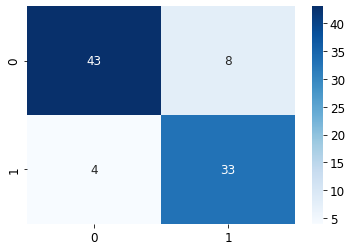

In [46]:
lr_model = LogisticRegression()
lr_model.fit(x_train,y_train)
accuracy_lr = lr_model.score(x_test,y_test)
print("Logistic Regression accuracy is :",accuracy_lr)
ly_pred= lr_model.predict(x_test)
report = classification_report(y_test,ly_pred)
print("-"*100)
print(report)
cm = confusion_matrix(y_test,lr_model.predict(x_test))
sns.heatmap(cm,annot=True,fmt="d",cmap = "Blues")

In [47]:
lfpr, ltpr, lthresholds = roc_curve(y_test, ly_pred)

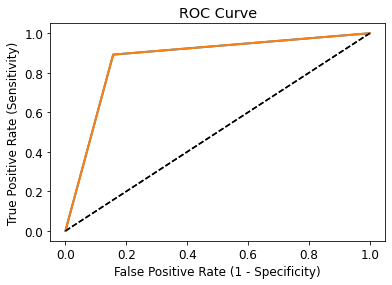

In [48]:
plot_roc_curve(lfpr, ltpr)
plt.show()

#### Naive Bayes

accuracy score =  0.7840909090909091
Report:               precision    recall  f1-score   support

           0       0.74      0.98      0.84        51
           1       0.95      0.51      0.67        37

    accuracy                           0.78        88
   macro avg       0.84      0.75      0.75        88
weighted avg       0.83      0.78      0.77        88



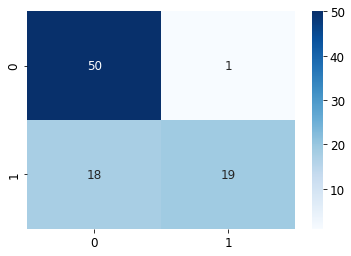

In [49]:
nb = GaussianNB()
nb.fit(x_train,y_train)

ny_pred = nb.predict(x_test)
cm = confusion_matrix(y_test,ny_pred)

nba = accuracy_score(y_test, ny_pred)
print('accuracy score = ', accuracy_score(y_test, ny_pred))
print("Report:", classification_report(y_test, ny_pred))

sns.heatmap(cm,annot=True,fmt="d",cmap = "Blues")

In [50]:
nfpr, ntpr, nthresholds = roc_curve(y_test, ny_pred)

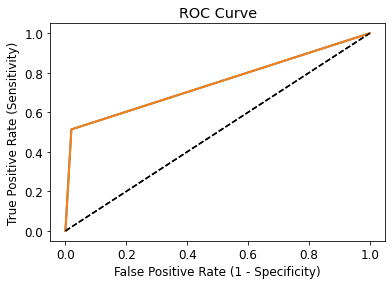

In [51]:
plot_roc_curve(nfpr, ntpr)
plt.show()

#### Linear Discriminant Analysis (LDA)

accuracy score =  0.8977272727272727
Report:               precision    recall  f1-score   support

           0       0.92      0.90      0.91        51
           1       0.87      0.89      0.88        37

    accuracy                           0.90        88
   macro avg       0.89      0.90      0.90        88
weighted avg       0.90      0.90      0.90        88



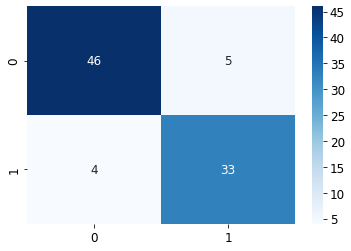

In [55]:
ld = LinearDiscriminantAnalysis()
ld.fit(x_train,y_train)

ldy_pred = ld.predict(x_test)
cm = confusion_matrix(y_test,ldy_pred)

lda = accuracy_score(y_test, ldy_pred)
print('accuracy score = ', accuracy_score(y_test, ldy_pred))
print("Report:", classification_report(y_test, ldy_pred))

sns.heatmap(cm,annot=True,fmt="d",cmap = "Blues")

In [73]:
grid = dict()
grid['solver'] = ['svd']

grid_search2 = GridSearchCV(ld, grid, scoring='accuracy', cv=5, n_jobs=-1)
results_2 = grid_search2.fit(x_train, y_train)

print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Mean Accuracy: 0.849
Config: {'reg_param': 1e-05, 'store_covariance': True, 'tol': 0.0001}


#### Quadratic Discrinminant Analysis (QDA)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


accuracy score =  0.8181818181818182
Report:               precision    recall  f1-score   support

           0       0.82      0.88      0.85        51
           1       0.82      0.73      0.77        37

    accuracy                           0.82        88
   macro avg       0.82      0.81      0.81        88
weighted avg       0.82      0.82      0.82        88



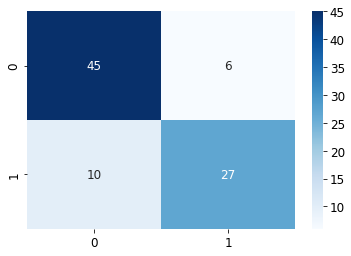

In [65]:
qd = QuadraticDiscriminantAnalysis()
qd.fit(x_train,y_train)

qdy_pred = qd.predict(x_test)
cm = confusion_matrix(y_test,qdy_pred)

qda = accuracy_score(y_test, qdy_pred)
print('accuracy score = ', accuracy_score(y_test, qdy_pred))
print("Report:", classification_report(y_test, qdy_pred))

sns.heatmap(cm,annot=True,fmt="d",cmap = "Blues")

In [74]:
parameters_2 = [{'reg_param': (0.00001, 0.0001, 0.001,0.01, 0.1), 
                 'store_covariance': (True, False),
                 'tol': (0.0001, 0.001,0.01, 0.1), 
                   }]

grid_search3 = GridSearchCV(qd, parameters_2, scoring='accuracy', cv=5, n_jobs=-1)
results_3 = grid_search3.fit(x_train, y_train)

print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Mean Accuracy: 0.849
Config: {'reg_param': 1e-05, 'store_covariance': True, 'tol': 0.0001}


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### Conclusion

Text(0.5, 1.0, 'Plotting the Model Accuracies')

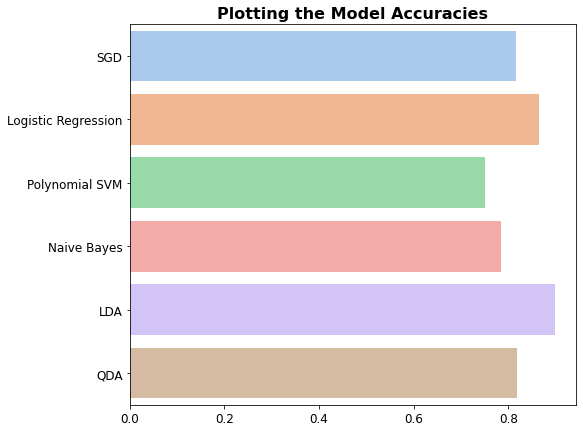

In [66]:
plt.figure(figsize= (8,7))
ac = [sgd_auc, accuracy_lr,psva,nba, lda, qda]
name = ['SGD','Logistic Regression','Polynomial SVM','Naive Bayes', 'LDA', 'QDA']
sns.barplot(x = ac,y = name,palette='pastel')
plt.title("Plotting the Model Accuracies", fontsize=16, fontweight="bold")